In [1]:
#library import
import pandas as pd # for data manipulation and analysis
import numpy as np # for scientific computing with Python
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline
import seaborn as sns # for advanced visualization

In [2]:
from collections import Counter

df= pd.read_csv('./Data/Preprocessed/fasttext_scratch_dataset.csv')
df_unbal_fasttext= df.copy()

# 80:20 split
from sklearn.model_selection import train_test_split

# Split into X and y
X = df_unbal_fasttext.drop('Target', axis=1)  # all columns except the 'Target' column
y = df_unbal_fasttext['Target']              # the 'Target' column

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

print(f'Train split Shape: {Counter(y_train)}')
print(f'Test split Shape: {Counter(y_test)}')


Train split Shape: Counter({1: 1086, 0: 721, 2: 200, 5: 127, 4: 86, 3: 67})
Test split Shape: Counter({1: 272, 0: 180, 2: 50, 5: 32, 4: 22, 3: 16})


In [3]:
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [4]:
# Class Weights using compute_class_weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Training SVC

svc = SVC(probability=True, class_weight=class_weights_dict, random_state=42)
svc.fit(X_train,y_train)

SVC(class_weight={0: 0.5286638927415627, 1: 0.35098219766728056,
                  2: 1.9058333333333333, 3: 5.689054726368159,
                  4: 4.432170542635659, 5: 3.0013123359580054},
    probability=True, random_state=42)

In [5]:
# Function to evaluate model and returns target predictions 
def make_scores(model, features, target):
    model_pred = model.predict(features)

    print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(model_pred , target))) 

    roc_auc = metrics.roc_auc_score(target , model.predict_proba(features), multi_class='ovr')
    print('AUC : {0:0.5f}'.format(roc_auc))

    print('Precision : {0:0.5f}'.format(metrics.precision_score(target , model_pred, average='macro')))
    print('Recall : {0:0.5f}'.format(metrics.recall_score(target , model_pred, average='macro')))
    print('F1 : {0:0.5f}'.format(metrics.f1_score(target , model_pred, average='macro')))
    print(classification_report(target, model_pred))
    
    return model_pred

# Scores of SVC
svc_pred=make_scores(svc, X_test, y_test)

Accuracy :0.23601
AUC : 0.62581
Precision : 0.16829
Recall : 0.19432
F1 : 0.10471
              precision    recall  f1-score   support

           0       0.50      0.07      0.12       180
           1       0.47      0.41      0.44       272
           2       0.00      0.00      0.00        50
           3       0.04      0.69      0.07        16
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00        32

    accuracy                           0.24       572
   macro avg       0.17      0.19      0.10       572
weighted avg       0.38      0.24      0.25       572



/home/angel-tamang/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/angel-tamang/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/angel-tamang/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/a

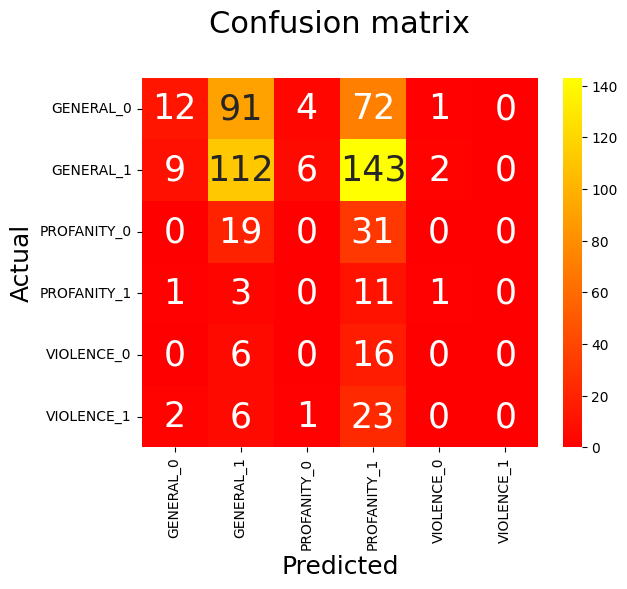

In [6]:
# Heatmap for Confusion Matrix
def make_confusion_matrix(target, prediction):
    cnf_matrix = metrics.confusion_matrix(target,prediction)
    cnf_matrix_df = pd.DataFrame(cnf_matrix,
                         index = ['GENERAL_0','GENERAL_1','PROFANITY_0','PROFANITY_1','VIOLENCE_0','VIOLENCE_1'], 
                         columns = ['GENERAL_0','GENERAL_1','PROFANITY_0','PROFANITY_1','VIOLENCE_0','VIOLENCE_1'])
    p = sns.heatmap(cnf_matrix_df, annot=True, annot_kws={"size": 25}, cmap="autumn" ,fmt='g')

    plt.title('Confusion matrix', y=1.1, fontsize = 22)
    plt.ylabel('Actual',fontsize = 18)
    plt.xlabel('Predicted',fontsize = 18)
    plt.show()

# Confusion Matrix for SVC
make_confusion_matrix(y_test,svc_pred)

Accuracy :0.39685
AUC : 0.59092
Precision : 0.26146
Recall : 0.27559
F1 : 0.25455
              precision    recall  f1-score   support

           0       0.69      0.64      0.66       180
           1       0.54      0.33      0.41       272
           2       0.13      0.20      0.16        50
           3       0.07      0.19      0.11        16
           4       0.07      0.14      0.10        22
           5       0.06      0.16      0.09        32

    accuracy                           0.40       572
   macro avg       0.26      0.28      0.25       572
weighted avg       0.49      0.40      0.43       572



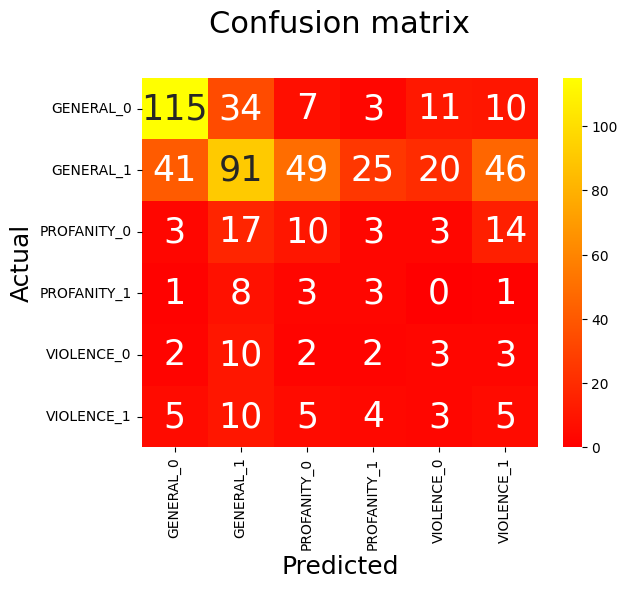

In [8]:
# adaBoost
# For models with no class_weight during initialization
sample_weights = np.array([class_weights_dict[label] for label in y_train])

ada_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42) 
ada_classifier.fit(X_train, y_train, sample_weight=sample_weights)

ada_classifier_pred= make_scores(ada_classifier, X_test, y_test)
make_confusion_matrix(y_test,ada_classifier_pred)

Accuracy :0.17657
AUC : 0.53484
Precision : 0.16663
Recall : 0.18765
F1 : 0.11102
              precision    recall  f1-score   support

           0       0.43      0.19      0.27       180
           1       0.47      0.20      0.28       272
           2       0.00      0.00      0.00        50
           3       0.04      0.69      0.07        16
           4       0.06      0.05      0.05        22
           5       0.00      0.00      0.00        32

    accuracy                           0.18       572
   macro avg       0.17      0.19      0.11       572
weighted avg       0.36      0.18      0.22       572



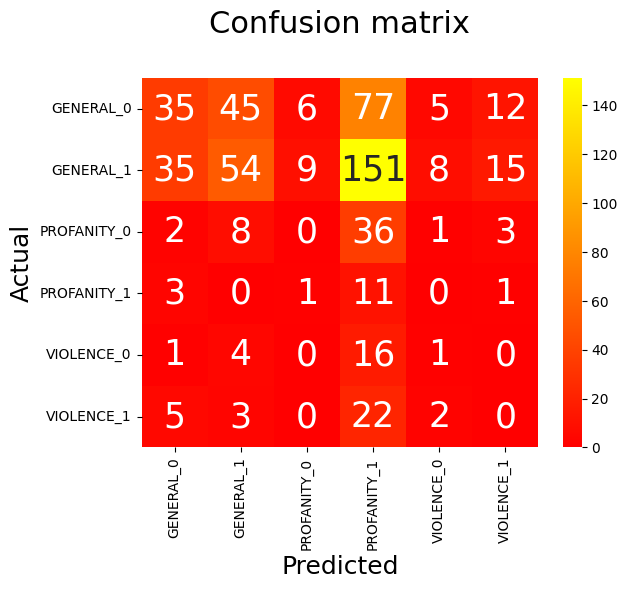

In [9]:
# Gaussian NB

gnb = GaussianNB()
gnb.fit(X_train, y_train, sample_weight=sample_weights)

gnb_pred= make_scores(gnb, X_test, y_test)
make_confusion_matrix(y_test, gnb_pred)

Accuracy :0.35140
AUC : 0.64835
Precision : 0.24833
Recall : 0.28419
F1 : 0.21871
              precision    recall  f1-score   support

           0       0.63      0.51      0.56       180
           1       0.56      0.34      0.42       272
           2       0.16      0.10      0.12        50
           3       0.06      0.62      0.10        16
           4       0.08      0.14      0.10        22
           5       0.00      0.00      0.00        32

    accuracy                           0.35       572
   macro avg       0.25      0.28      0.22       572
weighted avg       0.48      0.35      0.39       572



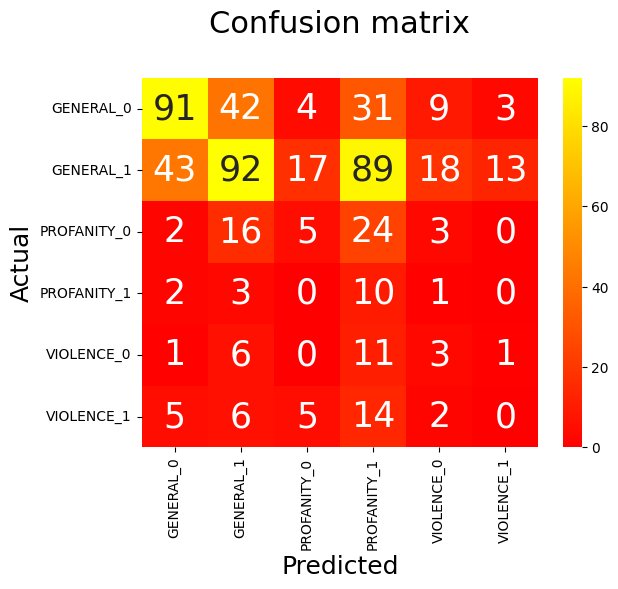

In [10]:
# Logistic Regression

lr= LogisticRegression(random_state=42, class_weight= class_weights_dict)
lr.fit(X_train, y_train)

lr_pred= make_scores(lr, X_test, y_test)
make_confusion_matrix(y_test, lr_pred)

Accuracy :0.53322
AUC : 0.63900
Precision : 0.25416
Recall : 0.24468
F1 : 0.24606
              precision    recall  f1-score   support

           0       0.72      0.63      0.67       180
           1       0.57      0.68      0.62       272
           2       0.07      0.06      0.07        50
           3       0.00      0.00      0.00        16
           4       0.17      0.09      0.12        22
           5       0.00      0.00      0.00        32

    accuracy                           0.53       572
   macro avg       0.25      0.24      0.25       572
weighted avg       0.51      0.53      0.52       572



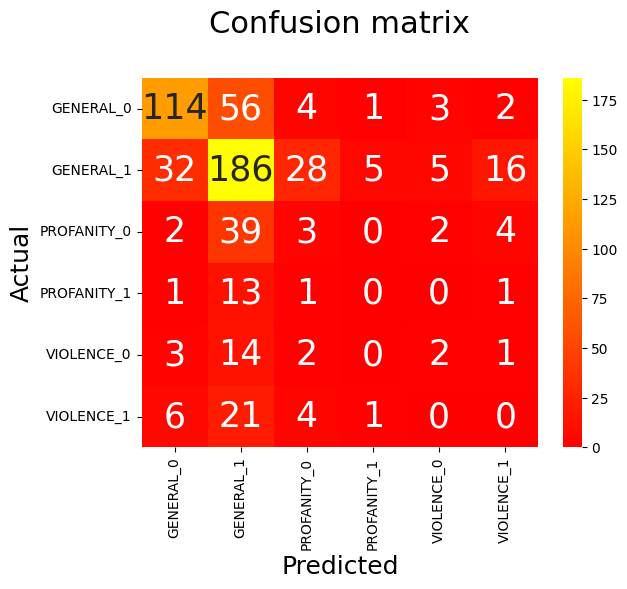

In [11]:
xg = XGBClassifier(random_state= 42)
xg.fit(X_train, y_train, sample_weight=sample_weights)

xg_pred= make_scores(xg, X_test, y_test)
make_confusion_matrix(y_test, xg_pred)